Extracting parameters from data/sub-01/eeg/sub-01_task-MOBAgame_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 10005699  =      0.000 ... 10005.699 secs...


C:\Users\amang\AppData\Local\Temp\ipykernel_23104\167313543.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  events_df = pd.read_csv('data/derivatives/markers/sub-01_task-MOBAgame_marker.txt', delim_whitespace=True, header=None, skiprows=1)


Writing C:\Users\amang\courses\eeg-hidden-markov-model\subject1_cropped_raw.fif
Closing C:\Users\amang\courses\eeg-hidden-markov-model\subject1_cropped_raw.fif
[done]
Cropped data saved as 'subject1_cropped_raw.fif'.
Opening raw data file subject1_cropped_raw.fif...
Isotrak not found
    Range : 56435 ... 1836523 =     56.435 ...  1836.523 secs
Ready.
Reading 0 ... 1780088  =      0.000 ...  1780.088 secs...
Filtering raw data in 89 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA...
Fitting ICA to data using 66 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 48.5s.
ICA fitting complete.
Using EOG channel: FP1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- L

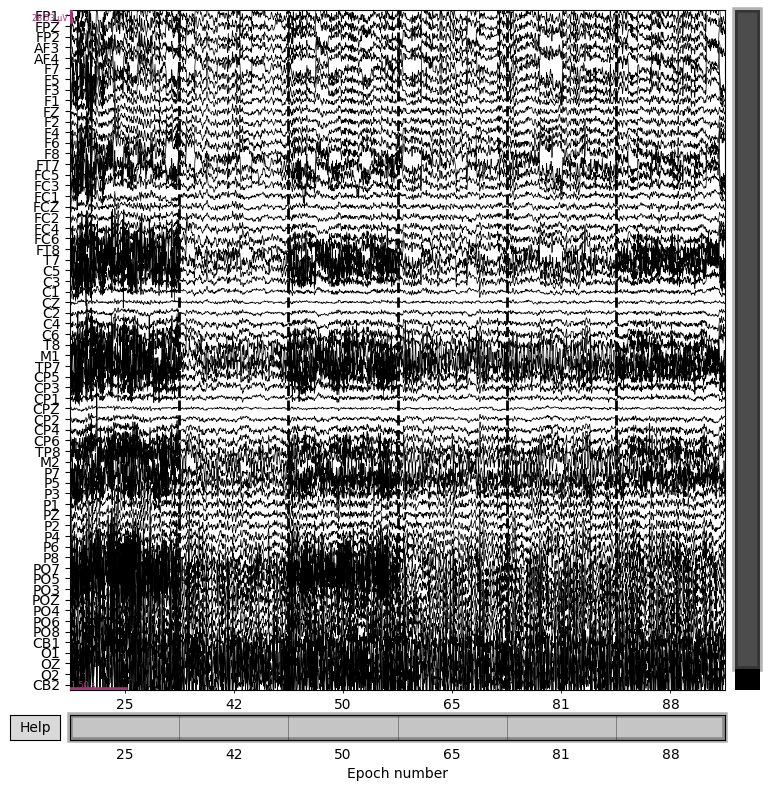

Epochs saved as 'subject1_epochs-epo.fif'.


In [3]:
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import ICA

# Step 1: Load Raw Data and Events
raw = mne.io.read_raw_brainvision('data/sub-01/eeg/sub-01_task-MOBAgame_eeg.vhdr', preload=True)

events_df = pd.read_csv('data/derivatives/markers/sub-01_task-MOBAgame_marker.txt', delim_whitespace=True, header=None, skiprows=1)
events_array = events_df.to_numpy().astype(int)

events_mne = np.column_stack((
    events_array[:, 0],
    np.zeros(len(events_array), dtype=int),
    events_array[:, 1]
)).astype(int)

# Step 2: Define Event IDs
event_id = {
    'Kill': 13,
    'Death': 14,
    'Game Start': 66,
    'Game Victory': 666,
    'Game Failure': 444
}
event_types = list(event_id.values())

# Step 3: Crop Raw Data Around Each Event
pre_event_time = 10.0  # seconds
post_event_time = 10.0  # seconds
sfreq = raw.info['sfreq']
segments = []
adjusted_events = []
cumulative_samples = 0

for i, event in enumerate(events_mne):
    event_sample = event[0]
    event_id = event[2]
    
    if event_id not in event_types:
        continue
    
    event_time = event_sample / sfreq
    tmin = event_time - pre_event_time
    tmax = event_time + post_event_time
    tmin = max(tmin, raw.times[0])
    tmax = min(tmax, raw.times[-1])
    
    if tmin >= tmax:
        print(f"Event at {event_time:.2f}s: Invalid time window after adjustment. Skipping event.")
        continue
    
    segment = raw.copy().crop(tmin=tmin, tmax=tmax)
    adjusted_sample = int((pre_event_time) * sfreq)
    adjusted_event = [cumulative_samples + adjusted_sample, 0, event_id]
    adjusted_events.append(adjusted_event)
    segments.append(segment)
    cumulative_samples += len(segment.times)

if segments:
    concatenated_raw = mne.concatenate_raws(segments)
    adjusted_events = np.array(adjusted_events).astype(int)
    concatenated_raw.save('subject1_cropped_raw.fif', overwrite=True)
    print("Cropped data saved as 'subject1_cropped_raw.fif'.")
else:
    print("No segments were extracted. Please check the events and data.")
    raise ValueError("No segments extracted.")

# Step 4: Load Cropped Data
raw_cropped = mne.io.read_raw_fif('subject1_cropped_raw.fif', preload=True)
events_cropped = adjusted_events

# Step 5: Apply Bandpass Filtering
raw_cropped.filter(1., 40., fir_design='firwin', verbose=True)

# Step 6: Perform ICA
ica = ICA(n_components=15, random_state=97, max_iter='auto')
print("Fitting ICA...")
ica.fit(raw_cropped)
print("ICA fitting complete.")

eog_channels = ['FP1', 'FP2']
eog_inds = []

for ch in eog_channels:
    if ch in raw_cropped.ch_names:
        inds, scores = ica.find_bads_eog(raw_cropped, ch_name=ch)
        eog_inds.extend(inds)

ica.exclude = list(set(eog_inds))
print(f"ICA components to exclude: {ica.exclude}")
ica.apply(raw_cropped)
print("ICA applied to the cropped data.")

# Step 7: Create Epochs
tmin, tmax = -1.0, 2.0
epochs = mne.Epochs(
    raw_cropped,
    events_cropped,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    picks='eeg',
    preload=True,
    reject=None,
    flat=None,
    reject_by_annotation=False,
    verbose=True
)
epochs.apply_baseline(baseline=(None, 0))
print(f"Total epochs: {len(epochs)}")
print("Event counts after epoching:", epochs.event_id)

# Step 8: Verify Epochs and Plot
if len(epochs.drop_log) > 0:
    print("Dropped epochs and reasons:")
    for idx, reason in enumerate(epochs.drop_log):
        if reason != ():
            print(f"Epoch {idx}: {reason}")

epochs.plot(n_channels=64, scalings='auto', n_epochs=10)

# Step 9: Save the Epochs
epochs.save('subject1_epochs-epo.fif', overwrite=True)
print("Epochs saved as 'subject1_epochs-epo.fif'.")
